"""  #    
# Trabajo final de Aprendizaje No Supervisado
- **Coordinador**: Adrien Felipe
- **Secretaria**: Carolina Martínez
- **Revisor**: Enrique Navarro

"""  #

# Datasets
## Preparación
### Librerías

In [24]:
import pandas as pd
import seaborn as sns
import numpy as np
import itertools as it
import matplotlib.pyplot as plt

# Para las medidas extrínsecas
from sklearn import metrics, datasets
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, MeanShift, SpectralClustering
from sklearn.metrics import davies_bouldin_score, pairwise_distances
from sklearn.metrics.cluster import contingency_matrix
from scipy.cluster.hierarchy import linkage, cut_tree

# Eliminamos avisos molestos
import warnings
warnings.filterwarnings("ignore")

"""  #    
### Funciones de apoyo
#### Función de carga del dataset
Se crea una función para simplificar la carga del dataset, que acepta varios parámetros:
 - dataset_url: cadena con la ruta al recurso desde donde cargar el dataset.
 - attributes: qué atributos usar del dataset (pocisión y nombre).
 - separator (opcional): caracter de división en el origen del dataset.
 - class_position (opcional): ubicación en el dataset de la clase.

"""  #


In [25]:
def load_dataset(dataset_url: str, attributes: dict, separator: str = '\s+', class_position: int = None):
    """Load a dataset from a specified url into a pandas DataFrame.

    :param str dataset_url: an url from a text based dataset
    :param dict attributes: attributes to keep in dictionary form:
        key: attribute position, value: attribute name
    :param str separator: file separator.
    :param int class_position: column index where classes are defined (starts by 0)
        if left empty (None), no prediction class will be used (intrinsic case).
    """
    # Load dataset as a pandas DataFrame from a specified url.
    dataset = pd.read_csv(dataset_url, sep=separator, header=None)

    # Add class index to the indexes to extract.
    if class_position is not None:
        attributes[class_position] = 'classes'

    # Keep only desired attributes and classes.
    dataset = dataset[attributes]

    # Force all values to be numeric.
    for (column, values) in dataset.iteritems():
        # Do not transform classes.
        if column == class_position:
            continue

        # Coerce transforms non-numeric values into NaN.
        dataset[column] = pd.to_numeric(values, errors='coerce')

    # Remove all NaN rows.
    dataset.dropna(inplace=True)

    # Extrinsic case, dataset comes with its classes.
    if class_position is not None:
        # Extract classes.
        classes = dataset[class_position]
        # Remove classes from attributes.
        dataset.drop(class_position, axis=1, inplace=True)

    # Intrinsic case, dataset has no classes.
    else:
        classes = None

    # Set attributes title.
    dataset.rename(columns=attributes, inplace=True)

    return classes, dataset


"""  #    
#### Función de visualización
Creamos también una función para simplificar la visualización del dataset.   
Esta función presenta una combinación de dos en dos de todos los atributos, asi como adapta las dimensiones de la gráfica según la cantidad de sub-gráficas a presentar.

Recibe dos parámetros:
 - atributos: El DataFrame con los atributos a representar
 - clase (opcional): El DataFrame con la clase de cada instancia

"""  #


In [26]:
def plot_dataset(dataset: pd.DataFrame, classes: np.array = None) -> None:
    # Combine all attributes two by two.
    combinations = list(it.combinations(dataset.columns, r=2))
    # Limit the number of plot columns.
    max_cols = 4
    cols = len(combinations) if len(combinations) <= max_cols else max_cols
    # From the columns number, set rows number.
    rows = int(np.ceil(len(combinations) / cols))

    # Calculate plot sizes depending on subplots number.
    size_x = int(13 * cols / max_cols) + 7
    size_y = 6 if rows * cols == 1 else 5 * rows

    # Build up all subplot combinations.
    fig, ax = plt.subplots(rows, cols, figsize=(size_x, size_y))
    for key, pair in enumerate(combinations):
        # Calculate plot axis position from sub-plot key.
        column = key % cols
        row = int(key / cols) % rows
        # Position needs to be a list when multiple rows.
        position = column if rows == 1 else (row, column)
        # Ax is not an array when single row and column.
        subplot = ax if rows * cols == 1 else ax[position]

        # Plot attributes values and titles.
        subplot.scatter(dataset[pair[0]], dataset[pair[1]], c=classes)
        subplot.set_title(str(pair[0]) + ' / ' + str(pair[1]))


"""  #    
## Métricas
### Funciones de cálculo de medidas extrínsecas

"""  #

In [27]:
def matriz_confusion(cat_real, cat_pred):
    cats = np.unique(cat_real)
    clusts = np.unique(cat_pred)
    mat = np.array([[np.sum(np.logical_and(cat_real == cats[i], cat_pred == clusts[j]))
                     for j in np.arange(clusts.size)]
                    for i in np.arange(cats.size)])
    return (mat)


In [28]:
def medida_error(mat):
    assign = np.sum([np.max(mat[l, :]) for l in np.arange(mat.shape[0])])
    return 1 - assign / float(np.sum(mat))


def medida_precision(mat, l, k):
    return mat[l, k] / sum(mat[:, k])


def medida_recall(mat, l, k):
    return mat[l, k] / sum(mat[l, :])


def medida_pureza(mat):
    totales = np.sum(mat, axis=0) / float(np.sum(mat))
    return np.sum([
        totales[k] * np.max(mat[:, k] / float(np.sum(mat[:, k])))
        for k in np.arange(mat.shape[1])
    ])


In [29]:
def medida_f1_especifica(mat, l, k):
    prec = medida_precision(mat, l, k)
    rec = medida_recall(mat, l, k)
    if (prec + rec) == 0:
        return 0
    else:
        return 2 * prec * rec / (prec + rec)


def medida_f1(mat):
    totales = np.sum(mat, axis=1) / float(np.sum(mat))
    assign = np.sum([
        totales[l] * np.max([
            medida_f1_especifica(mat, l, k)
            for k in np.arange(mat.shape[1])
        ])
        for l in np.arange(mat.shape[0])
    ])
    return assign


In [30]:
def medida_entropia(mat):
    totales = np.sum(mat, axis=0) / float(np.sum(mat))
    relMat = mat / np.sum(mat, axis=0)
    logRelMat = relMat.copy()
    logRelMat[logRelMat == 0] = 0.0001  # Evita el logaritmo de 0. Inofensivo pues luego desaparece al multiplicar por 0
    logRelMat = np.log(logRelMat)
    return -np.sum([
        totales[k] * np.sum([
            relMat[l, k] * logRelMat[l, k]
            for l in np.arange(mat.shape[0])
        ])
        for k in np.arange(mat.shape[1])
    ])


"""  #     
#### Función de cálculo de las medidas extrínsecas
Función que calcula varias medidas cualitativas del agrupamiento, de forma a poder comparar cada algoritmo.
 - Error, pureza, entropía, información mutua y F1 tal como se han visto en clase.
 - ARI mide la similaridad entre las clases y los predichos
 - Homogeneidad (todos los valores predichos son del clúster correcto)
 - Completación (todos los valores de una clase se predicen en el mismo clúster)
 - Medida V (media armónica de homogeneidad y completación). Parámetro beta (por defecto 1) para ponderar
 - Fowlkes-Mallows es la media geométrica de las parejas precision-recall
 - Silhouette
 - Calinski-Harabasz
 - Davies-Bouldin

"""  #


In [31]:
def calculate_extrinsic_metrics(dataset, real_classes, predicted_classes):
    confusion_matrix = matriz_confusion(real_classes, predicted_classes)

    return {
        'Error': medida_error(confusion_matrix),
        'Pureza': medida_pureza(confusion_matrix),
        'F1': medida_f1(confusion_matrix),
        'Entropía': medida_entropia(confusion_matrix),
        'Información mútua': metrics.mutual_info_score(real_classes, predicted_classes),
        'ARI': metrics.adjusted_rand_score(real_classes, predicted_classes),
        'Homogeneidad': metrics.homogeneity_score(real_classes, predicted_classes),
        'Completación': metrics.completeness_score(real_classes, predicted_classes),
        'Medida V': metrics.v_measure_score(real_classes, predicted_classes),
        'Fowlkes-Mallows': metrics.fowlkes_mallows_score(real_classes, predicted_classes),
        'Silhouette': metrics.silhouette_score(dataset, predicted_classes, metric='euclidean'),
        'Calinski-Harabasz': metrics.calinski_harabasz_score(dataset, predicted_classes),
        'Davies-Bouldin': davies_bouldin_score(dataset, predicted_classes)
    }


"""  #    
### Funciones de cálculo de medidas intrínsecas
Añadimos las funciones de cálculo de métricas intrínsecas no disponibiles directamente en python o por lo menso en sklearn.

"""  #


In [32]:
def RMSSTD_score(dataset, prediction, centers):
    # Extract all individual predicted classes.
    labels = np.unique(prediction)

    numerator = np.sum([
        np.sum(np.sum(dataset[prediction == label] - centers[label], axis=1) ** 2)
        for label in labels
    ])

    denominator = dataset.shape[1] * np.sum([
        np.sum(prediction == label) - 1
        for label in labels
    ])

    return np.sqrt(numerator / denominator)


In [33]:
def r2_score(dataset, prediction, centroids):
    """
    An intrinsic R² score metric, as sklearn one is extrinsic only.
    """
    attributes_mean = np.mean(dataset, axis=0)
    labels = np.sort(np.unique(prediction))
    numerator = np.sum([
        np.sum(np.sum(dataset[prediction == label] - centroids[label], axis=1) ** 2)
        for label in labels
    ])
    denominator = np.sum(np.sum(dataset - attributes_mean, 1) ** 2)

    return 1 - numerator / denominator


In [34]:
def distancia_euclidiana(x, y):
    return np.sqrt(np.sum((x - y) ** 2))


def distance_matrix(X, distancia):
    mD = np.zeros((X.shape[0], X.shape[0]))
    for pair in it.product(np.arange(X.shape[0]), repeat=2):
        mD[pair] = distancia(X[pair[0], :], X[pair[1], :])
    return mD


def medida_I(dataset, prediction, centers, distance_function, p=1):
    attributes_mean = np.mean(dataset, axis=0)
    labels = np.sort(np.unique(prediction))
    distance_max = np.max(distance_matrix(centers, distance_function))

    num = np.sum([distance_function(instance, attributes_mean) for instance in dataset.values])

    den = len(labels) * np.sum([
        np.sum([
            distance_function(dataset.iloc[i], centers[k])
            for i in np.arange(dataset.shape[0])[prediction == labels[k]]
        ])
        for k in np.arange(centers.shape[0])
    ])

    return (num / den * distance_max) ** p


"""  #    
#### Función de cálculo de las medidas intrínsecas
Función que calcula varias medidas cualitativas del agrupamiento.
 - Silhouette
 - Calinski-Harabasz
 - Davies-Boudin
 

No usamos RMSSTD, R² y Medida I al estas nececitar centroides, pero no todos los algoritmos lo contemplan.

"""  #


In [35]:
def calculate_intrinsic_metrics(dataset, prediction):
    return {
        'Silhouette': metrics.silhouette_score(dataset, prediction),
        'Calinski Harabasz': metrics.calinski_harabasz_score(dataset, prediction),
        'Davies Bouldin': metrics.davies_bouldin_score(dataset, prediction)
    }


""" #    
### Presentación métricas
Usaremos la función a continuación para presentar la comparación de las métricas, usando una media comparativa.

""" #

In [115]:
def compare_metrics(metrics_data: dict) -> pd.DataFrame:
    output = pd.DataFrame(metrics_data)
    output.loc['mean'] = output.mean(axis=0)

    return output

## Selección

"""  #    
### Dataset extrínseca
El origen de este dataset se remonta a datos usados en 1983 por la <i>American Statistical Association Exposition</i> y que se conservan en la Universidad de Carnegie Mellon, al que le faltan 8 instancias que se eliminaron para homogeneizar el dataset, ya que carecían del campo mpg.
 
 El dataset consta de:
 - 392 instancias
 - 8 atributos, que son:    
     · mpg (millas por galón de combustible): de tipo continuo.    
     · cylinders (cilindros): discreto multi evaluado.    
     · displacement (cilindrada): continuo.    
     · horsepower (caballos de potencia): continuo.    
     · weight (peso): continuo    
     · acceleration (aceleración): continuo    
     · model-year (año del modelo): discrto multi evaluado.    
     · origin (origen): discreto multi evaluado.    
     · car name (nombre del coche): cadena (único para cada instancia)    

Para el estudio que nos ocupa vamos a predecir el número de cilindros basándonos en la cilindrada y la potencia.

"""  #

In [36]:
# Cargamos el dataset.
dataset_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
attributes = {0: 'mpg', 2: 'cilindrada', 3: 'potencia'}
extrinsic_classes, extrinsic_dataset = load_dataset(dataset_url, attributes, class_position=1)

# Soporte para las métricas
extrinsic_metrics = {}

"""  #    
Se descartan el resto de valores para mantener baja la dimensión del vector descriptor y simplificar así los cálculos.
Los datos vienen casi listos para trabajar con ellos. No se detectan campos vacíos:

"""  #

In [37]:
print(extrinsic_dataset.isnull().any())

mpg           False
cilindrada    False
potencia      False
dtype: bool


""" #    
Sin embargo, en la potencia hay un valor anómalo, un "?" usado donde se desconocía el dato, por lo que se ha incorporado a la función de carga de datos un filtro para eliminarlo, ajustable por parámetro (limpiarNA)

Vamos a observar la distribución de nuestra clase:

""" #

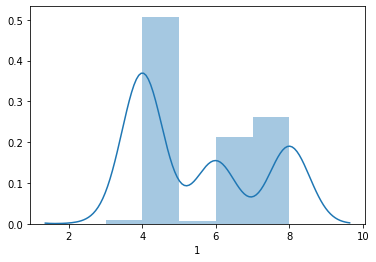

In [38]:
sns.distplot(extrinsic_classes)

""" #    
Se observa una marcada preponderancia de los valores de cilindros 4,6 y 8. Asumimos que probablemente las instancias que no pertenezcan a estos tres grupos se agrupen dentro de ellos lo que va a conllevar un pequeño error de base al escoger agrupamientos.

""" #

""" #    
Y la relación entre los atributos:

""" #

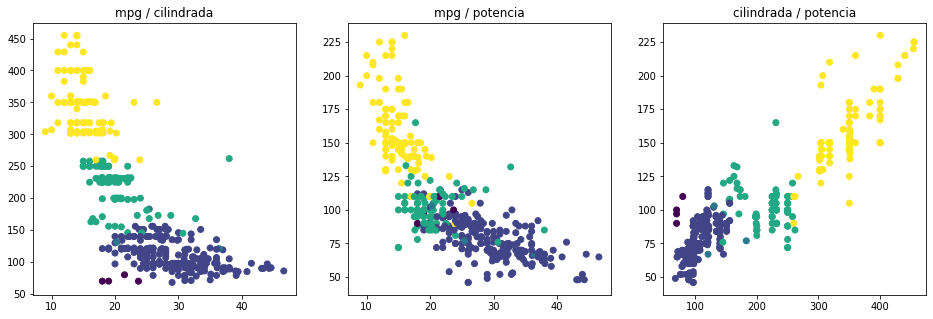

In [39]:
plot_dataset(extrinsic_dataset, extrinsic_classes)

"""  #    
## Dataset intrínseca
El dataset intrínseca **Aggregations** está generado de manera artificial por: *A. Gionis, H. Mannila, and P. Tsaparas, Clustering aggregation. ACM Transactions on Knowledge Discovery from Data (TKDD), 2007*


Este dataset está compuesto por 788 observaciones de 2 variables que abarcan un amplio rango numérico. En el conjunto de datos existen entre 5 a 7 grupos que se distribuyen en zonas particulares del rango de valores de las variables.


Cargamos nuestro dataset (*intrinsic_dataset*):

"""  #

In [40]:
# Cargamos el dataset.
dataset_url = 'http://cs.joensuu.fi/sipu/datasets/Aggregation.txt'
attributes = {0: 'dim 1', 1: 'dim 2'}
_, intrinsic_dataset = load_dataset(dataset_url, attributes)

# Soporte para las métricas
intrinsic_metrics = {}

"""  #    
Visualizamos el dataset en 2-D.

"""  #

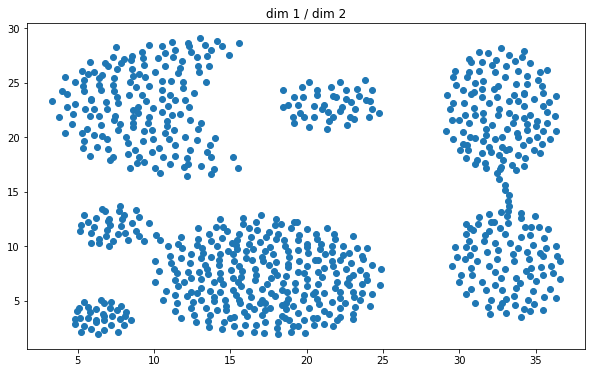

In [41]:
plot_dataset(intrinsic_dataset)

"""  #    
Destacamos que se podría clasificar con 4, 5 o con 7 clusters.

"""  #

"""  #    
# Algoritmos
## Selección de clusters
"""  #

In [55]:
def plot_clusters_selection(dataset: pd.DataFrame, max_clusters: int = 10):
    dataset = np.array(dataset)
    silhouette_values = []
    r2_values = []
    min_clusters = 2

    for k in np.arange(min_clusters, max_clusters):
        model = KMeans(n_clusters=k).fit(dataset)
        prediction = model.predict(dataset)
        centroids = model.cluster_centers_

        silhouette_values += [metrics.silhouette_score(dataset, prediction)]
        r2_values += [r2_score(dataset, prediction, centroids)]

    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    ax[0].plot(np.arange(min_clusters, max_clusters), silhouette_values, linestyle='-', marker='o')
    ax[0].set_xlabel("Número de clústeres")
    ax[0].set_ylabel("Medida de ancho de silueta")

    ax[1].plot(np.arange(min_clusters, max_clusters), r2_values, linestyle='-', marker='o')
    ax[1].set_xlabel("Número de clústeres")
    ax[1].set_ylabel("Medida de R cuadrado")


# Análisis dataset extrínseca

"""  #    

### Selección del número de clusters

A fin de implementar el modelo de K-Medios, comencemos por determinar la cantidad óptima de centroides a utilizar a partir del Método del Codo.

"""  #

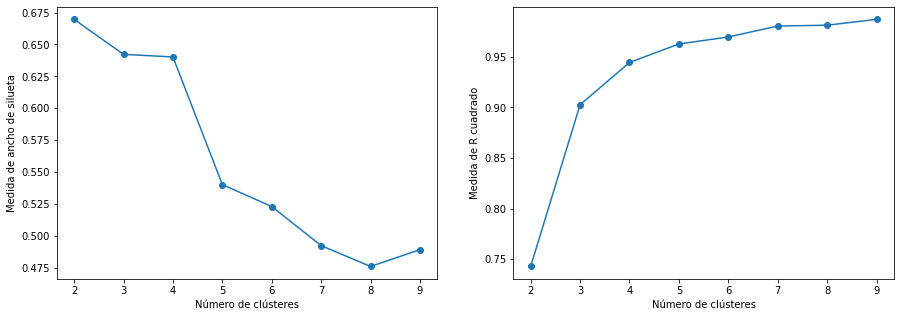

In [56]:
plot_clusters_selection(extrinsic_dataset)

"""  #    
Observando los datos es evidente que el número óptimo de clústers para K-means es 3.

"""  #

In [61]:
extrinsic_clusters=4

## Algoritmos
### Algoritmo 1: K medias

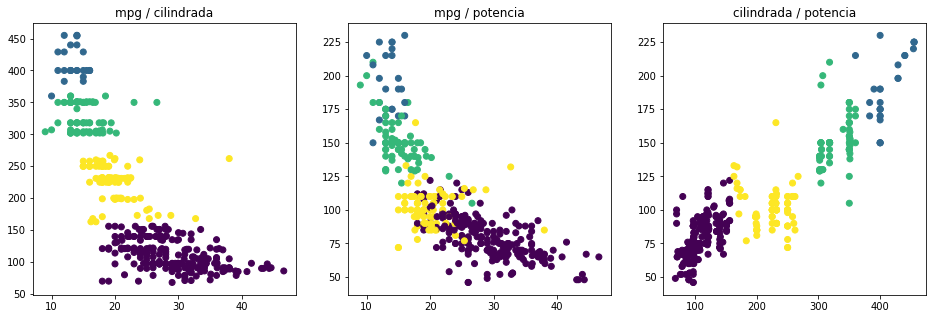

In [53]:
model = KMeans(n_clusters=extrinsic_clusters).fit(extrinsic_dataset)
prediction = model.predict(extrinsic_dataset)
extrinsic_metrics['k-means'] = calculate_extrinsic_metrics(extrinsic_dataset, extrinsic_classes, prediction)

plot_dataset(extrinsic_dataset, prediction)

"""  #     
por corregir: k-means no ha sido capaz de encontrar el pequeño grupo

"""  #

### Algoritmo 2: jerárquico aglomerativo
#### Ejecución del algoritmo

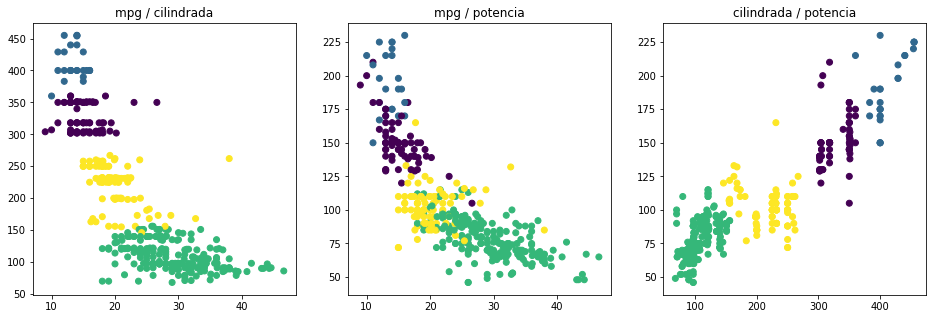

In [62]:
# Generamos el modelo.
model = linkage(extrinsic_dataset, 'average')
prediction = cut_tree(model, n_clusters=extrinsic_clusters).flatten()
# Guardamos la métricas.
extrinsic_metrics['Jerárquico'] = calculate_extrinsic_metrics(extrinsic_dataset, extrinsic_classes, prediction)

# Presentamos los clusters.
plot_dataset(extrinsic_dataset, prediction)

""" #    
tampoco ha cojido el pequeño grupo

""" #

### Algoritmo 3: DBSCAN

Mejor distancia identificada: 24.5


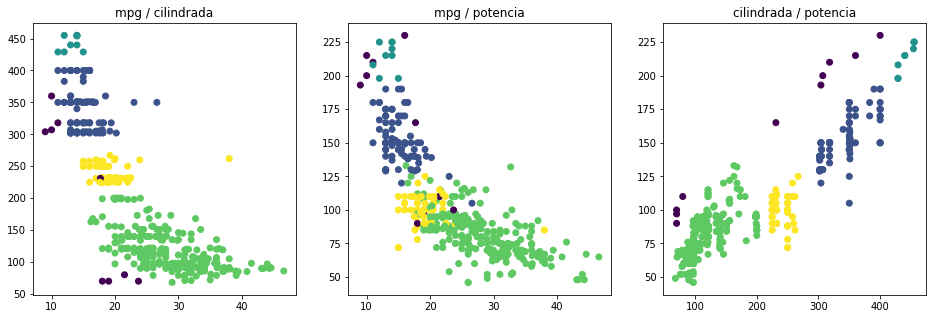

In [97]:
def calcular_DBSCAN(eps):
    modelo = DBSCAN(eps=eps).fit(extrinsic_dataset)
    labels_pred = modelo.labels_
    x = calculate_extrinsic_metrics(extrinsic_dataset, extrinsic_classes, labels_pred)
    media = (x['ARI']+x['Información mútua']+x['Homogeneidad']+x['Completación']+x['Medida V']+x['Fowlkes-Mallows'])/6
    return {"modelo": modelo, "mediciones": x, 'media': media, "prediction": labels_pred}


def repetir_dbscan(r):
    r *= 2
    res = {"media": 0}
    for i in np.arange(20 * 2, r + 1):
        x = calcular_DBSCAN(i / 2)
        if x["media"] > res["media"]:
            res = x
            res["distancia"] = i / 2
    return res


eps = 30  # Distancia máxima a probar (en pasos de 0.5)
best = repetir_dbscan(eps)
print("Mejor distancia identificada:", best["distancia"])
extrinsic_metrics["DBSCAN"] = best["mediciones"]

plot_dataset(extrinsic_dataset, best["prediction"])

### Algoritmo 4: Deslizamiento de media

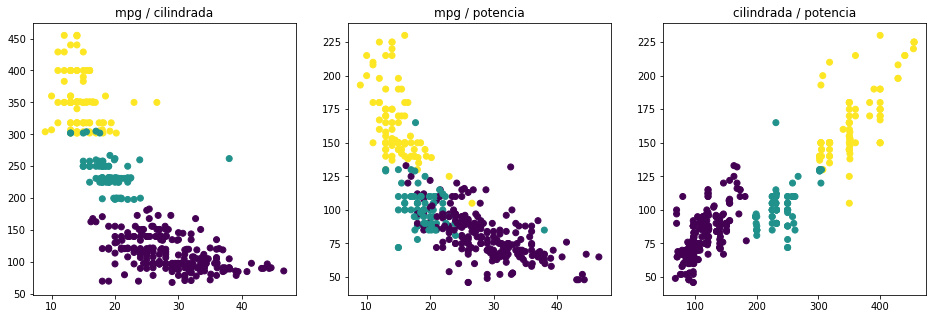

In [110]:
# Generamos el modelo.
model = MeanShift().fit(extrinsic_dataset)
prediction = model.labels_

# Guardamos la métricas.
extrinsic_metrics['Means-Shift'] = calculate_extrinsic_metrics(extrinsic_dataset, extrinsic_classes, prediction)

# Presentamos los clusters.
plot_dataset(extrinsic_dataset, prediction)

### Algritmo 5: Espectral

In [113]:
def mejor_espectral(nn):
    vecinos = 0
    media_max = 0
    modelo_fin = None
    for i in np.arange(nn):
        modelo = SpectralClustering(affinity='nearest_neighbors',n_neighbors=i+1).fit(extrinsic_dataset)
        labels_pred = modelo.labels_
        x = calculate_extrinsic_metrics(extrinsic_dataset,extrinsic_classes,labels_pred)
        x['media'] = (x['ARI']+x['Información mútua']+x['Homogeneidad']+x['Completación']+x['Medida V']+x['Fowlkes-Mallows'])/6
        if x["media"] > media_max:
            vecinos = i+1
            media_max = x["media"]
            modelo_fin = modelo
    return {"modelo":modelo_fin, "vecinos":vecinos, "mediciones":x, "prediction":labels_pred}

def repetir_espectral(v,r):
    print("Buscando mejor clustering espectral.\nProbando de 1 a",v,"vecinos más cercanos y repitiendo",r,"veces.\nTiempo de ejecución estimado:",int((v/53)*3*r),"segundos.")
    mejor = {"mediciones": {"media":0}}
    for i in np.arange(r+1):
        res = mejor_espectral(v)
        if res["mediciones"]["media"] > mejor["mediciones"]["media"]:
            mejor = res
    return mejor


vecinos = 50
repeticiones = 20
best = repetir_espectral(vecinos, repeticiones)
print("El mejor espectral encontrado es con", best["vecinos"], "vecinos y da una media de", best["mediciones"]["media"])
for key, value in best["mediciones"].items():
    print(key, ":", value)
extrinsic_metrics["Espectral"] = best["mediciones"]["media"]

plot_dataset(extrinsic_dataset, best["prediction"])

Buscando mejor clustering espectral.
Probando de 1 a 50 vecinos más cercanos y repitiendo 20 veces.
Tiempo de ejecución estimado: 56 segundos.


KeyboardInterrupt: 

### Comparación algoritmos

In [116]:
display(compare_metrics(extrinsic_metrics))

,k-means,Jerárquico,DBSCAN,Means-Shift
Error,0.096939,0.091837,0.122449,0.068878
Pureza,0.954082,0.959184,0.895408,0.913265
F1,0.905991,0.911279,0.874093,0.904644
Entropía,0.210296,0.194421,0.324870,0.317746
Información mútua,0.897830,0.913705,0.783256,0.790380
ARI,0.839870,0.854311,0.730511,0.794505
Homogeneidad,0.810224,0.824550,0.706830,0.713258
Completación,0.778479,0.783064,0.706785,0.803680
Medida V,0.794034,0.803272,0.706807,0.755774
Fowlkes-Mallows,0.899217,0.907665,0.836886,0.876179


"""  #    
Como se puede observar a continuación, si comparamos una media de las medidas calculadas, el algoritmo que mejor agrupa nuestros datos es K-medias.

"""  #

# Análisis dataset intrínseca
## Algoritmos

"""  #    
### Algoritmo 1: K medias
#### Selección del número de clusters

A fin de implementar el modelo de K-Medios, comencemos por determinar la cantidad óptima de centroides a utilizar a partir del Método del Codo.

"""  #

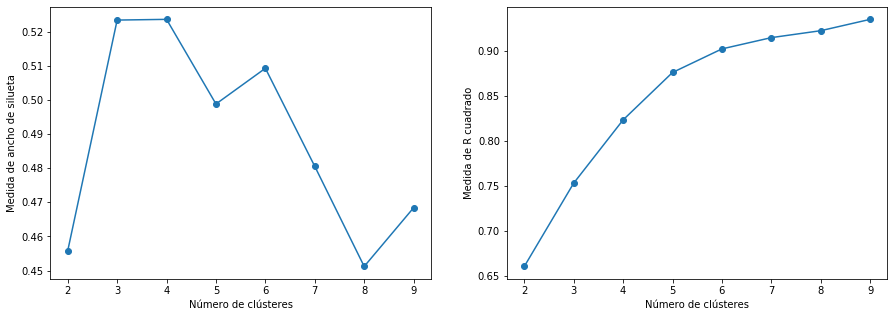

In [163]:
plot_clusters_selection(intrinsic_dataset)

"""  #    
Según el procedimiento del codo, escogeríamos entre 5 y 7 clusters

"""  #

"""  #
#### Ejecución del algoritmo
Ejecutamos la predicción de k-means con 5 clusters y visualizamos la agrupación generada.


"""  #

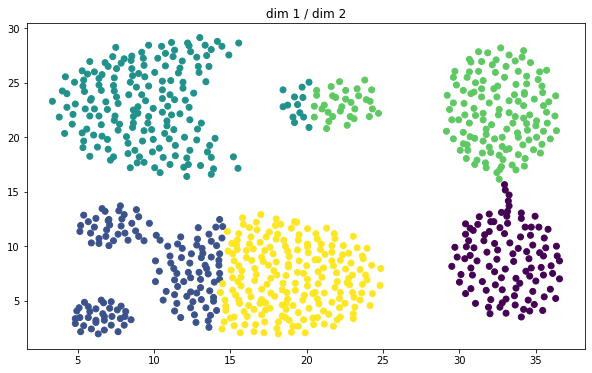

In [164]:
# Generamos el modelo.
model = KMeans(n_clusters=5).fit(intrinsic_dataset)
prediction = model.predict(intrinsic_dataset)

# Guardamos la métricas.
intrinsic_metrics['k-means'] = calculate_intrinsic_metrics(intrinsic_dataset, prediction)

# Presentamos los clusters.
plot_dataset(intrinsic_dataset, prediction)

"""  #    
Vemos que mientras se han logrado aislar algunos grupos, otros claramente se han quedado a medias.

"""  #

### Algoritmo Jerárquico Aglomerativo

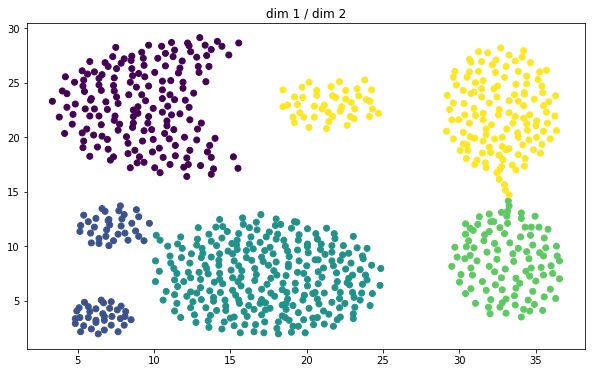

In [165]:
model = linkage(intrinsic_dataset, 'average')
prediction = cut_tree(model, n_clusters=5).flatten()
intrinsic_metrics['Jerárquico'] = calculate_intrinsic_metrics(intrinsic_dataset, prediction)

plot_dataset(intrinsic_dataset, prediction)

### Algoritmo Agrupamiento espectral

/opt/anaconda/lib/python3.7/site-packages/sklearn/manifold/spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


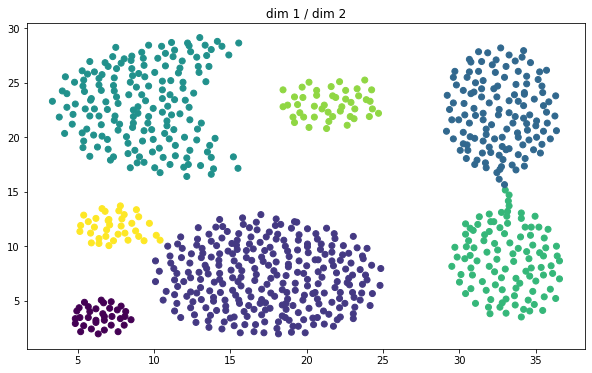

In [166]:
K = 7
knn = 30
model = SpectralClustering(
    n_clusters=K, affinity='nearest_neighbors', n_neighbors=knn, random_state=0
).fit(intrinsic_dataset)
prediction = model.labels_
intrinsic_metrics['Espectral'] = calculate_intrinsic_metrics(intrinsic_dataset, prediction)

plot_dataset(intrinsic_dataset, prediction)

"""  #    
El jerarquico con 30 KNN resuelve bien la clusterización con 7 grupos, si se reduce no lo hace tan bien, y  partir de 50 tampoco. Hay que encontar el valor correcto.    
Buscando 5 clusters tambien lo hace bien.

"""  #

### Algoritmo Mean Shift

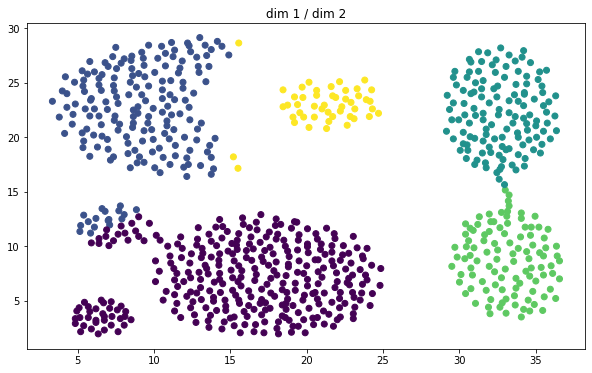

In [167]:
h = 6
model = MeanShift(bandwidth=h).fit(intrinsic_dataset)
prediction = model.labels_
intrinsic_metrics['Means-Shift'] = calculate_intrinsic_metrics(intrinsic_dataset, prediction)

plot_dataset(intrinsic_dataset, prediction)

### Algoritmo EM

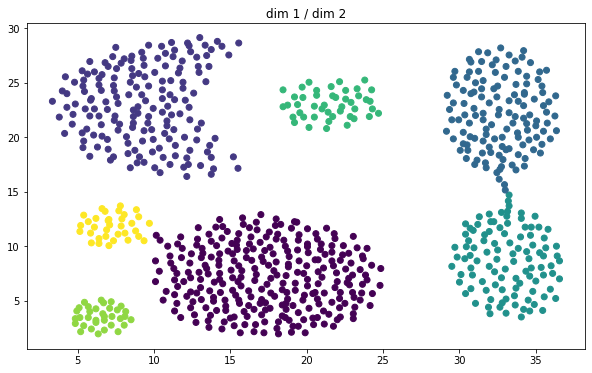

In [174]:
from sklearn.mixture import GaussianMixture

model = GaussianMixture(n_components=7, max_iter=1000).fit(intrinsic_dataset)
prediction = model.predict(intrinsic_dataset)
intrinsic_metrics['EM'] = calculate_intrinsic_metrics(intrinsic_dataset, prediction)

plot_dataset(intrinsic_dataset, prediction)

"""  #    
Este a veces la clava y a veces no. Hay que darle varias veces. Es curioso.

"""  #

### Comparación algoritmos

In [73]:
display(add_metrics_mean(intrinsic_metrics))

ValueError: cannot set a frame with no defined columns

"""  #     
blabla comparación dataset intrinseco

"""  #

# Conclusión